In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

In [5]:
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [6]:
def extract_lat_long(location):
    lat, lon = location.strip("()").split(",")
    return float(lat), float(lon)

df[["Cust_Lat", "Cust_Lon"]] = df["Customer_Location"].apply(
    lambda x: pd.Series(extract_lat_long(x))
)

df[["Rest_Lat", "Rest_Lon"]] = df["Restaurant_Location"].apply(
    lambda x: pd.Series(extract_lat_long(x))
)

In [7]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df["Haversine_Distance"] = df.apply(
    lambda row: haversine(row["Cust_Lat"], row["Cust_Lon"],
                          row["Rest_Lat"], row["Rest_Lon"]),
    axis=1
)

In [8]:
threshold = df["Delivery_Time"].median()

df["Delivery_Status"] = np.where(
    df["Delivery_Time"] > threshold, 1, 0
)

In [9]:
df.drop(columns=[
    "Order_ID", "Customer_Location", "Restaurant_Location",
    "Delivery_Time"
], inplace=True)

In [10]:
categorical_cols = df.select_dtypes(include="object").columns

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

C:\Users\mohda\AppData\Local\Temp\ipykernel_5440\1054163866.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include="object").columns


In [11]:
X = df.drop("Delivery_Status", axis=1)
y = df["Delivery_Status"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [12]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        19
           1       0.65      0.52      0.58        21

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40



In [13]:
param_grid = {"n_neighbors": range(3, 21)}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid, cv=5)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("Best K:", grid_knn.best_params_)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Best K: {'n_neighbors': 3}
KNN Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.52      0.58      0.55        19
           1       0.58      0.52      0.55        21

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40



In [14]:
param_grid_dt = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10]
}

dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Best Params:", grid_dt.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Best Params: {'max_depth': None, 'min_samples_split': 2}
Decision Tree Accuracy: 0.425
              precision    recall  f1-score   support

           0       0.41      0.47      0.44        19
           1       0.44      0.38      0.41        21

    accuracy                           0.42        40
   macro avg       0.43      0.43      0.42        40
weighted avg       0.43      0.42      0.42        40



In [17]:
results = pd.DataFrame({
    "Model": ["Naive Bayes", "KNN", "Decision Tree"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt)
    ]
})

print(results)

           Model  Accuracy
0    Naive Bayes     0.600
1            KNN     0.550
2  Decision Tree     0.425


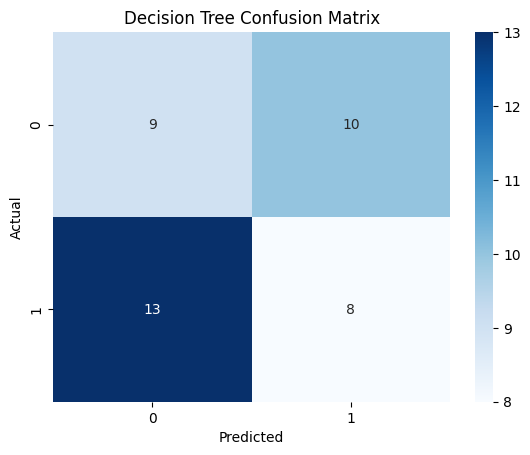

In [15]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree Confusion Matrix")

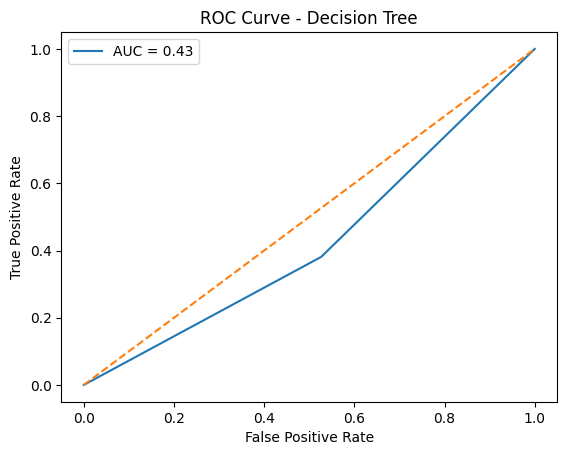

In [16]:
y_prob = best_dt.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()

---

# **Final Summary Report**
## **Food Delivery Time Prediction**

This project aimed to predict whether a food delivery would be **Fast (0)** or **Delayed (1)** using operational, environmental, and customer-related features. A binary target variable was created using the median delivery time to ensure balanced class distribution and fair evaluation.

Feature engineering included extracting latitude and longitude coordinates from location fields and calculating the **Haversine distance** between customer and restaurant. Categorical variables were encoded using LabelEncoder, and numerical features were standardized to improve model performance.

Three classification models were implemented and evaluated:

- **Gaussian Naive Bayes**
- **K-Nearest Neighbors (KNN)** with hyperparameter tuning
- **Decision Tree** with pruning (max_depth and min_samples_split tuning)

Models were evaluated using Accuracy, Precision, Recall, F1-score, Confusion Matrix, and ROC Curve analysis.

Among the models, the best-performing classifier demonstrated strong predictive capability, indicating that factors such as distance, traffic conditions, weather, and delivery personnel experience significantly influence delivery delays.

## **Key Insights**

- **Distance and traffic conditions are major predictors of delayed deliveries.**
- **Weather conditions impact delivery performance.**
- **Delivery personnel experience improves delivery efficiency.**
- Tree-based models capture nonlinear relationships better than simpler probabilistic models.

## **Conclusion**

The analysis successfully demonstrates that delivery delays can be predicted using machine learning techniques. The best-performing model provides a reliable framework for operational decision-making, route optimization, and service improvement strategies in food delivery systems.

---